In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2
from nengo.dists import Uniform

In [2]:
# Define the maps

map_1 = np.array([
    [1, 2, 1],
    [1, 3, 5],
    [7, 1, 1]
])

map_2 = np.array([
    [1, 2, 1, 6],
    [1, 3, 5, 3],
    [7, 1, 4, 1]
])

map_3 = np.array([
    [1, 3, 7, 2, 1],
    [3, 1, 5, 3, 1],
    [3, 2, 6, 1, 2],
    [3, 1, 5, 6, 1],
    [2, 2, 1, 1, 2]
])


#this is where I select differnt maps
my_array = map_1

size_of_array = (my_array.size)


#finds how many in each row and columb.
num_rows,num_cols = my_array.shape

In [3]:
# Define custom classes for node behavior
class Inhibit:
    def __init__(self):
        self.spike_started = False
        self.spike_ended = False

    def inhibit(self, t, x):
        if not self.spike_started and x > 0.8:
            self.spike_started = True
        
        if self.spike_started and x < 0.1:
            self.spike_ended = True
        
        if not self.spike_ended:
            return x
        else:
            return 0
        
class Delay:
    def __init__(self, timesteps):
        self.history = np.zeros((timesteps, 1))
        self.spike_started = False
        self.spike_ended = False
        self.time_spike_started = None
        self.time_spike_ended = None

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        current_output = self.history[0]

        if not self.spike_started and current_output > 0.8:
            self.spike_started = True
            self.time_spike_started = t
        
        if self.spike_started and current_output < 0.1 and not self.spike_ended:
            self.spike_ended = True
            self.time_spike_ended = t

        return current_output


model = nengo.Network(label="Lab2 map", seed=123)
with model:

#node just passes value though 
#ensable is a bunch neruonrs. 
    # list of ensambles so should be the same dimensions as 'size_of_array'
    neurons = np.empty((num_rows, num_cols), dtype=object)

    # Fill the matrix with inhibition neurons
    n_neurons_map = 100
    for row in range(neurons.shape[0]):
        for col in range(neurons.shape[1]):
            map_ensemble = nengo.Ensemble(n_neurons=n_neurons_map, dimensions=1)
            inhibit = Inhibit()
            inhibit_node = nengo.Node(inhibit.inhibit, size_in = 1, size_out = 1)
            nengo.Connection(map_ensemble, inhibit_node)
            neurons[row, col] = [map_ensemble, inhibit_node, None]


In [4]:
# Define neighbors for each node
#CONNECTING TO OTHERS

#split map into sections: edge, corner, center
        
connect = np.empty((num_rows, num_cols), dtype=object)
# Fill the matrix with empty lists
for row in range(connect.shape[0]):
    for col in range(connect.shape[1]):
        connect[row, col] = []

for i in range(num_rows):
    for j in range(num_cols):
        #Edge TOP
        if (i==0) and (0 < j < num_cols-1):  
            connect[i, j].append([i, j+1])
            connect[i, j].append([i, j-1])
            connect[i, j].append([i+1, j+1])
            connect[i, j].append([i+1, j])
            connect[i, j].append([i+1, j-1])

        #Edge BOTTOM
        elif (i==num_rows-1) and (0 < j < num_cols-1):
            connect[i,j].append([i, j+1])
            connect[i,j].append([i, j-1])
            connect[i,j].append([i-1, j+1])
            connect[i,j].append([i-1, j])
            connect[i,j].append([i-1, j-1])

        #Edge LEFT
        elif (0 < i < num_rows-1) and (j==0):
            connect[i,j].append([i-1, j])
            connect[i,j].append([i-1, j+1])
            connect[i,j].append([i, j+1])
            connect[i,j].append([i+1, j+1])
            connect[i,j].append([i+1, j])

        #Edge RIGHT
        elif (0 < i < num_rows-1) and (j==num_cols-1):
            connect[i,j].append([i-1, j])
            connect[i,j].append([i-1, j-1])
            connect[i,j].append([i, j-1])
            connect[i,j].append([i+1, j-1])
            connect[i,j].append([i+1, j])
         
        #Corner TOP LEFT
        elif (i==0) and (j==0):
            connect[i,j].append([i, j+1])
            connect[i,j].append([i+1, j+1])
            connect[i,j].append([i+1, j])

        #Corner TOP RIGHT
        elif (i==0) and (j==num_cols-1):
            connect[i,j].append([i, j-1])
            connect[i,j].append([i+1, j-1])
            connect[i,j].append([i+1, j])

        #Corner BOTTOM LEFT
        elif (i==num_rows-1) and (j==0):
            connect[i,j].append([i-1, j])
            connect[i,j].append([i-1, j+1])
            connect[i,j].append([i, j+1])

        #Corner BOTTOM RIGHT
        elif (i==num_rows-1) and (j==num_cols-1):
            connect[i,j].append([i, j-1])
            connect[i,j].append([i-1, j-1])
            connect[i,j].append([i-1, j])
            
        #Center 
        else:
            connect[i,j].append([i-1, j])
            connect[i,j].append([i-1, j+1])
            connect[i,j].append([i, j+1])
            connect[i,j].append([i+1, j+1])
            connect[i,j].append([i+1, j])
            connect[i,j].append([i+1, j-1])
            connect[i,j].append([i, j-1])
            connect[i,j].append([i-1, j-1])

In [5]:
# Use the connect indices to connect each node's output inhibit node to a delay node with the node's weight and then to the neighboring map ensembles
with model:
    for row in range(num_rows):
        for col in range(num_cols):
            # Unload the map ensemble's output inhibit node
            map_inhibit_node = neurons[row, col][1]

            # Unload this node's weight/cost
            weight = my_array[row, col]

            # Create a delay node with the specified map weight
            delay = Delay(timesteps=weight * 1000)
            delay_node = nengo.Node(delay.step, size_in = 1, size_out = 1)

            # Save the delay object which will contain spike time
            neurons[row, col][2] = delay

            # Unload the neighbors for this map location
            my_neighbors = connect[row, col]
            for neighbor in my_neighbors:
                # Unload target map ensemble
                target_map_ensemble = neurons[neighbor[0], neighbor[1]][0]

                # Connect
                nengo.Connection(map_inhibit_node, delay_node)
                nengo.Connection(delay_node, target_map_ensemble)


In [6]:
# Connect input to first map node and run the sim

with model:
    inp_node = nengo.Node(Piecewise({0: 0, .25: 1, .5: 0})) # quick spike into start node
    start_location = (0, 0)
    inp_neuron = neurons[start_location[0], start_location[1]][0]
    nengo.Connection(inp_node,inp_neuron)
    
    probes = {}
    probes['input'] = nengo.Probe(inp_node, synapse=0.01)
    probes['00'] = nengo.Probe(neurons[0, 0][1],synapse=0.01)
    probes['01'] = nengo.Probe(neurons[0, 1][1], synapse=0.01)

# Build the simulator to run the model containing just input encoding
with nengo.Simulator(model) as sim:
    sim.run(10)


Build finished in 0:00:01.                                                      
Simulation finished in 0:00:15.                                                 


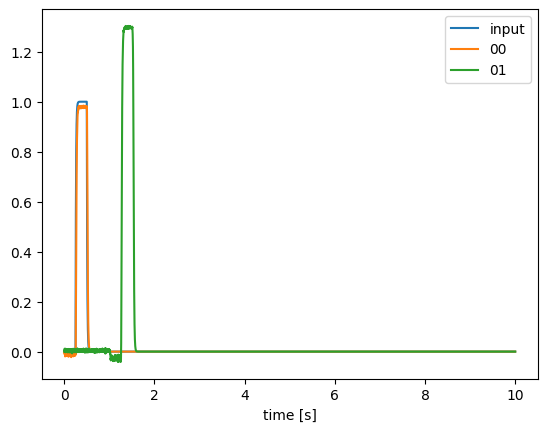

In [7]:
# Plot some probes
plt.figure()
for key in probes.keys():
    plt.plot(sim.trange(), sim.data[probes[key]], label=key)

plt.legend(loc=1)
plt.xlabel("time [s]")
plt.show()

In [8]:
# Find optimal path by looking at time of spike ending for each delay node
aer_matrix = np.zeros((num_rows, num_cols))
for row in range(num_rows):
    for col in range(num_cols):
        delay_object = neurons[row, col][2]
        spike_time = delay_object.time_spike_ended
        aer_matrix[row, col] = spike_time 

print(aer_matrix)

[[1.529 3.557 4.583]
 [2.558 4.563 8.751]
 [9.587 3.601 4.624]]
